In [45]:
import pandas as pd
import os
import glob
import numpy as np
from math import sqrt
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt


## DISCLAIMER: this function was made by Raphael Valentin. All rights reserved.
## source: https://stackoverflow.com/a/48085583/6361764
def cubic_interp1d(x0, x, y):
    """
    Interpolate a 1-D function using cubic splines.
      x0 : a float or an 1d-array
      x : (N,) array_like
          A 1-D array of real/complex values.
      y : (N,) array_like
          A 1-D array of real values. The length of y along the
          interpolation axis must be equal to the length of x.

    Implement a trick to generate at first step the cholesky matrice L of
    the tridiagonal matrice A (thus L is a bidiagonal matrice that
    can be solved in two distinct loops).

    additional ref: www.math.uh.edu/~jingqiu/math4364/spline.pdf 
    """
    x = np.asfarray(x)
    y = np.asfarray(y)

    # remove non finite values
    # indexes = np.isfinite(x)
    # x = x[indexes]
    # y = y[indexes]

    # check if sorted
    if np.any(np.diff(x) < 0):
        indexes = np.argsort(x)
        x = x[indexes]
        y = y[indexes]

    size = len(x)

    xdiff = np.diff(x)
    ydiff = np.diff(y)

    # allocate buffer matrices
    Li = np.empty(size)
    Li_1 = np.empty(size-1)
    z = np.empty(size)

    # fill diagonals Li and Li-1 and solve [L][y] = [B]
    Li[0] = sqrt(2*xdiff[0])
    Li_1[0] = 0.0
    B0 = 0.0 # natural boundary
    z[0] = B0 / Li[0]

    for i in range(1, size-1, 1):
        Li_1[i] = xdiff[i-1] / Li[i-1]
        Li[i] = sqrt(2*(xdiff[i-1]+xdiff[i]) - Li_1[i-1] * Li_1[i-1])
        Bi = 6*(ydiff[i]/xdiff[i] - ydiff[i-1]/xdiff[i-1])
        z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    i = size - 1
    Li_1[i-1] = xdiff[-1] / Li[i-1]
    Li[i] = sqrt(2*xdiff[-1] - Li_1[i-1] * Li_1[i-1])
    Bi = 0.0 # natural boundary
    z[i] = (Bi - Li_1[i-1]*z[i-1])/Li[i]

    # solve [L.T][x] = [y]
    i = size-1
    z[i] = z[i] / Li[i]
    for i in range(size-2, -1, -1):
        z[i] = (z[i] - Li_1[i-1]*z[i+1])/Li[i]

    # find index
    index = x.searchsorted(x0)
    np.clip(index, 1, size-1, index)

    xi1, xi0 = x[index], x[index-1]
    yi1, yi0 = y[index], y[index-1]
    zi1, zi0 = z[index], z[index-1]
    hi1 = xi1 - xi0

    # calculate cubic
    f0 = zi0/(6*hi1)*(xi1-x0)**3 + \
         zi1/(6*hi1)*(x0-xi0)**3 + \
         (yi1/hi1 - zi1*hi1/6)*(x0-xi0) + \
         (yi0/hi1 - zi0*hi1/6)*(xi1-x0)
    return f0

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path, "xls", "*.xls")) 

collection = [pd.read_excel(f, sheet_name=None, skiprows=1) for f in files]
df = pd.concat((v for j in collection for v in j.values()), ignore_index=True)

df = df.filter(items=["Dia", "Taxa Venda Manhã", "Emissão"])

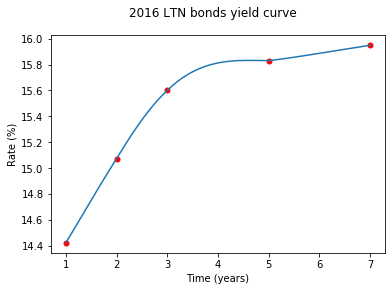

In [79]:
x = df[df["Dia"]=="01/02/2016"]["Emissão"]
y = df[df["Dia"]=="01/02/2016"]["Taxa Venda Manhã"]*100
x_new = np.linspace(x.iloc[0], x.iloc[-1], 201)

plt.plot(x, y, 'ro', ms=5)
plt.plot(x_new, cubic_interp1d(x_new, x, y))
plt.suptitle("2016 LTN bonds yield curve")
plt.xlabel("Time (years)")
plt.ylabel("Rate (%)")
plt.savefig("report/Figure_0.png")

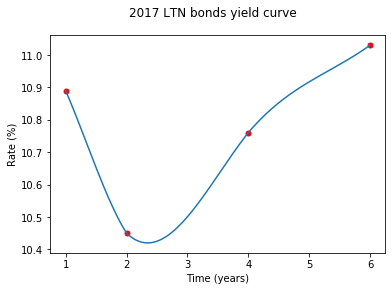

In [80]:
x = df[df["Dia"]=="01/02/2017"]["Emissão"]
y = df[df["Dia"]=="01/02/2017"]["Taxa Venda Manhã"]*100
x_new = np.linspace(x.iloc[0], x.iloc[-1], 201)

plt.plot(x, y, 'ro', ms=5)
plt.plot(x_new, cubic_interp1d(x_new, x, y))
plt.suptitle("2017 LTN bonds yield curve")
plt.xlabel("Time (years)")
plt.ylabel("Rate (%)")
plt.savefig("report/Figure_1.png")

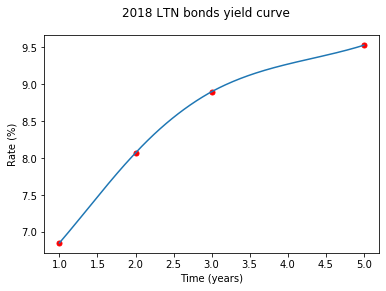

In [81]:
x = df[df["Dia"]=="01/02/2018"]["Emissão"]
y = df[df["Dia"]=="01/02/2018"]["Taxa Venda Manhã"]*100
x_new = np.linspace(x.iloc[0], x.iloc[-1], 201)

plt.plot(x, y, 'ro', ms=5)
plt.plot(x_new, cubic_interp1d(x_new, x, y))
plt.suptitle("2018 LTN bonds yield curve")
plt.xlabel("Time (years)")
plt.ylabel("Rate (%)")
plt.savefig("report/Figure_2.png")